### import modules

In [1]:
import numpy as np
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline
# to remove depreciationWarning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from pprint import pprint

- Import NLTK for common stop words
- This list of stopwords will be extended. The extension words are corpus specific

In [2]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['tagum', 'city', 'davao','ordinance','ii', 'penalties','nd','within','every','otherwise','thereof','section', 'municipal', 'municipality', 'government', 'series', 'continue', 'reading'])
# stop_words.extend(['ordinance','tagum','city','thereof','section','municipal','municipality','ii'])

### Import Tagum dataset

In [3]:
df = pd.read_csv('ordinances/tagum_ordinances.csv', header = 0)
print(df)
df.head()

                                     OR  \
0        CITY ORDINANCE No. 842, s-2018   
1        CITY ORDINANCE NO. 825, s-2017   
2        CITY ORDINANCE NO. 837, s-2018   
3        CITY ORDINANCE NO. 844, s-2018   
4        CITY ORDINANCE NO. 838, s-2018   
..                                  ...   
670  MUNICIPAL ORDINANCE NO. 05, s-1974   
671  MUNICIPAL ORDINANCE NO. 04, s-1974   
672  MUNICIPAL ORDINANCE NO. 01, s-1974   
673    MUNICIPAL ORDINANCE NO. 03, 1973   
674  MUNICIPAL ORDINANCE NO. 02, S-1973   

                                                    OT  
0    “AN ORDINANCE REGULATING THE PRACTICE OF TRADI...  
1    “AN ORDINANCE RECONSTITUTING THE MEMBERS OF TH...  
2    “AN ORDINANCE ESTABLISHING FUNERAL AND BURIAL ...  
3    AN ORDINANCE AMENDING THE TITLE, SECTION 1, SE...  
4    “AN ORDINANCE CREATING THE CITY HISTORICAL, CU...  
..                                                 ...  
670  “AN ORDINANCE AMENDING SECTION 10 OF MUNICIPAL...  
671  “AN ORDINANCE REGULATI

,OR,OT
0,"CITY ORDINANCE No. 842, s-2018",“AN ORDINANCE REGULATING THE PRACTICE OF TRADI...
1,"CITY ORDINANCE NO. 825, s-2017",“AN ORDINANCE RECONSTITUTING THE MEMBERS OF TH...
2,"CITY ORDINANCE NO. 837, s-2018",“AN ORDINANCE ESTABLISHING FUNERAL AND BURIAL ...
3,"CITY ORDINANCE NO. 844, s-2018","AN ORDINANCE AMENDING THE TITLE, SECTION 1, SE..."
4,"CITY ORDINANCE NO. 838, s-2018","“AN ORDINANCE CREATING THE CITY HISTORICAL, CU..."


Add ordinance descriptions to a list

In [4]:
data = list(df.OT) 
print(data[:1]) # preview

['“AN ORDINANCE REGULATING THE PRACTICE OF TRADITIONAL HOME BIRTH DELIVERY OR DELIVERIES ATTENDED BY A TRADITIONAL BIRTH ATTENDANT OR MANANABANG”.']


Use regular expression to remove words ending with ING.
(Seems to improve topics)

In [5]:
import re
data = [re.sub("\'", "", sent) for sent in data]
data = [re.sub("\"", "", sent) for sent in data]
data = [re.sub('\S*ING\S*\s?', '', sent) for sent in data]

Tokenize and preprocess text

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

pprint(data_words[:1])

[['an',
  'ordinance',
  'the',
  'practice',
  'of',
  'traditional',
  'home',
  'birth',
  'delivery',
  'or',
  'deliveries',
  'attended',
  'by',
  'traditional',
  'birth',
  'attendant',
  'or',
  'mananabang']]


In [7]:
# Remove Stop Words
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words_nostops = remove_stopwords(data_words)

# Create Dictionary
id2word = corpora.Dictionary(data_words_nostops)

# Create Corpus
texts = data_words_nostops

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2)]]


In [8]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('attendant', 1),
  ('attended', 1),
  ('birth', 2),
  ('deliveries', 1),
  ('delivery', 1),
  ('home', 1),
  ('mananabang', 1),
  ('practice', 1),
  ('traditional', 2)]]

In [9]:
# Build LDA model

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,workers=3,
                                           num_topics=15, 
                                           random_state=123,
                                           
                                           chunksize=100,
                                           passes=30,
                                          
                                           per_word_topics=True)

In [10]:
doc_lda = lda_model[corpus]

In [11]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=123,
                                           chunksize=100,
                                           passes=30,
                                           workers=3,
                                           per_word_topics=True)
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

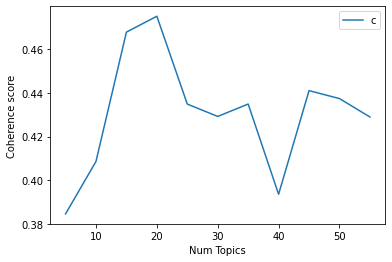

Num Topics = 5  has Coherence Value of 0.3845
Num Topics = 10  has Coherence Value of 0.4086
Num Topics = 15  has Coherence Value of 0.4679
Num Topics = 20  has Coherence Value of 0.4752
Num Topics = 25  has Coherence Value of 0.4349
Num Topics = 30  has Coherence Value of 0.4292
Num Topics = 35  has Coherence Value of 0.4349
Num Topics = 40  has Coherence Value of 0.3935
Num Topics = 45  has Coherence Value of 0.441
Num Topics = 50  has Coherence Value of 0.4374
Num Topics = 55  has Coherence Value of 0.429


In [12]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=5, limit=60, step=5)

# Show graph to find optimal number of topics
# Coherence value not going flat seems unlikely or probably wrong
limit=60; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

K = 15 is the optimal number of topics since when

In [24]:
optimal_model = model_list[3] # when number of topics is 15
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.036*"violation" + 0.022*"known" + 0.021*"business" + 0.019*"revised" + '
  '0.018*"implementation" + 0.018*"province" + 0.017*"fees" + '
  '0.016*"regulations" + 0.016*"students" + 0.014*"use"'),
 (1,
  '0.023*"resolution" + 0.022*"zone" + 0.018*"national" + 0.018*"industrial" + '
  '0.015*"certain" + 0.015*"provisions" + 0.015*"part" + 0.015*"repealed" + '
  '0.015*"modified" + 0.015*"inconsistent"'),
 (2,
  '0.039*"street" + 0.039*"temporary" + 0.028*"portion" + 0.027*"closed" + '
  '0.027*"traffic" + 0.026*"bonifacio" + 0.020*"roxas" + 0.019*"vehicular" + '
  '0.019*"bounded" + 0.019*"parcel"'),
 (3,
  '0.035*"year" + 0.033*"fees" + 0.026*"school" + 0.025*"pesos" + 0.024*"lot" '
  '+ 0.018*"amount" + 0.017*"high" + 0.016*"tuition" + 0.016*"office" + '
  '0.015*"uy"'),
 (4,
  '0.030*"inside" + 0.018*"scholars" + 0.018*"nutrition" + 0.018*"houses" + '
  '0.016*"residential" + 0.014*"bns" + 0.014*"movie" + 0.013*"step" + '
  '0.013*"persons" + 0.012*"night"'),
 (5,
  '0.051*"

In [25]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,18.0,0.9208,"street, office, market, road, terminal, business, mayor, trucks, public, inspection",“AN ORDINANCE THE PRACTICE OF TRADITIONAL HOME BIRTH DELIVERY OR DELIVERIES ATTENDED BY A TRADITIONAL BIRTH ATTENDANT OR MANANABANG”.
1,1,7.0,0.8100,"public, vehicles, utility, violations, violation, jeepneys, buses, passenger, poblacion, tricycle","“AN ORDINANCE THE MEMBERS OF THE CITY TRICYCLE AND REGULATORY BOARD (CTFRB) ITS FUNCTIONS AND PROCEDURES AND MOTORIZED TRICYCLE FOR HIRE (MTH), TRICYCLE UTILITY VEHICLE (TUV) AND TRICYCLE UTILITY FOR HIRE (TUH) GUIDELINES, REGULATIONS AND OPERATIONS, THE COLLECTION OF FEES, CHARGES,ADMINISTRATIVE PROVISIONS AND PENALTIES FOR VIOLATION THEREOF”."
2,2,13.0,0.8150,"funds, position, duties, market, purpose, necessary, officer, legislative, functions, development","“AN ORDINANCE FUNERAL AND BURIAL ASSISTANCE FOR INDIGENT TAGUMENYOS, ITS MANAGEMENT, PROCEDURES AND GUIDELINES AND FUNDS THEREFOR”."
3,3,5.0,0.5654,"barangay, area, meters, tct, square, lot, thousand, located, hundred, pesos","AN ORDINANCE THE TITLE, SECTION 1, SECTION 2 AND SECTION 3 OF CITY ORDINANCE NO. 820, S-2017 “AN ORDINANCE INTO A LOAN AGREEMENT WITH THE DEVELOPMENT BANK OF THE PHILIPPINES, IN THE AMOUNT OF SIX HUNDRED EIGHTY MILLION PESOS (P 680,000,000.00) TO FUND THE ACQUISITION OF HEAVY EQUIPMENT,ACQUISITION OF SERVICE VEHICLES, ACQUISITION OF continue reading : CITY ORDINANCE NO. 844, s-2018"
4,4,11.0,0.6054,"violations, house, girls, examination, complete, employment, pleasure, hospitality, without, medical","“AN ORDINANCE THE CITY HISTORICAL, CULTURAL AND ARTS COUNCIL IN THE CITY OF TAGUM”."
5,5,2.0,0.8167,"street, temporary, portion, closed, traffic, bonifacio, roxas, vehicular, bounded, parcel","“AN ORDINANCE THE HUGPONG SERBISYO PARA SA TAGUMENYOS FESTIVAL, ITS GUIDELINES AND FUNDS THEREOF”."
6,6,11.0,0.2563,"violations, house, girls, examination, complete, employment, pleasure, hospitality, without, medical",“AN ORDINANCE THE AREA IN FRONT OF THE HISTORICAL AND CULTURAL CENTER AS THE RIZAL PARK OF TAGUM CITY”.
7,7,0.0,0.9050,"violation, known, business, revised, implementation, province, fees, regulations, students, use","AN ORDINANCE SECTION 2 OF CITY ORDINANCE NO. 287, S-2008, “AN ORDINANCE A TECHNICAL VOCATIONAL INSTITUTE IN THE CITY OF TAGUM, PROVINCE OF DAVAO DEL NORTE TO BE KNOWN AS TAGUM CITY TRADE SCHOOL”."
8,8,12.0,0.4778,"plaza, park, administrator, services, granted, construction, portion, position, serve, shall",AN ORDINANCE THE TEMPORARY CLOSURE OF PORTIONS OF ARELLANO AND BONIFACIO STREETS FOR THE TRADE FAIR ACTIVITY AS PART OF THE COOP MONTH CELEBRATION 2017 FROM 4:00 IN THE AFTERNOON TILL 11:00 IN THE
9,9,9.0,0.7062,"purposes, roads, streets, violations, violation, provided, use, hereunder, portion, poblacion","“AN ORDINANCE TEMPORARY CLOSURE FROM CORNER RIZAL AND OSMEÑA STREETS TO CORNER RIZAL AND BONIFACIO STREETS TO CORNER BONIFACIO AND MABINI STREETS, ALL OF BARANGAY MAGUGPO POBLACION, TAGUM CITY FOR THE 22ND MINDANAO AREA SPECIAL ASSEMBLY OF THE ORDER OF THE KNIGHTS OF RIZAL ON OCTOBER 7, 2017, SATURDAY FROM TWELVE NOON (12:00 NN) continue reading : CITY ORDINANCE NO. 828, S- 2017"


In [30]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 1000

documents_topic = pd.DataFrame()


sent_topics_sorteddf = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf.head(20)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9604,"violation, known, business, revised, implementation, province, fees, regulations, students, use","“AN ORDINANCE ALL CONTRACTOR/CONSTRUCTOR NATIONAL FUNDED INFRASTRUCTURE PROJECTS IN THE MUNICIPALITY OF TAGUM TO SUBMIT A COPY OF THE PROGRAM OF WORK ITS DESIGN AND CONTRACT ENTERED INTO BY THE CONTRACTOR/CONSTRUCTOR WITH THE DEPARTMENT OF PUBLIC WORKS AND HIGHWAYS (DPWH) AND ALL OTHER NATIONAL GOVERNMENT AGENCIES TO THE MUNICIPAL MAYOR OF continue reading : MUNICIPAL ORDINANCE NO. 10, s-1991"
1,1.0,0.9500,"resolution, zone, national, industrial, certain, provisions, part, repealed, modified, inconsistent","AN ORDINANCE A ONE STOP SHOP MEDICAL, DENTAL AND LABORATORY SERVICES FOR UNDERPRIVILEGED CONSTITUENTS SPECIFICALLY for Pregnant and Lactating Mothers, Malnourished Preschoolers and School Children IN THE 23 BARANGAYS OF TAGUM CITY."
2,2.0,0.9568,"street, temporary, portion, closed, traffic, bonifacio, roxas, vehicular, bounded, parcel","“AN ORDINANCE THE TEMPORARY CLOSURE OF VARIOUS ROADS WITHIN THE CITY OF TAGUM AS RACE ROUTES FOR MUSA MAN TRIDAVNOR (TRIATHLON RACE) ACTIVITY AS PART OF THE CELEBRATION OF THE 50TH ARAW NG DAVAO DEL NORTE ON JUNE 25, 2017 FROM 5:30 IN THE TO 12:30 IN THE AFTERNOON”."
3,3.0,0.9604,"year, fees, school, pesos, lot, amount, high, tuition, office, uy","“AN ORDINANCE LOT 1025-D-3-A, PSD-11-009520, A PORTION OF LOT 1025-D-3, PSD-266850 OWNED BY ISIDORO T. UY SITUATED IN BARANGAY MAGDUM, TAGUM, DAVAO, BOUNDED ON THE NE., POINTS 1-2 BY LOT 1025-D-3-B; ON THE SE., POINTS 2-3 BY LOT 375, CAD. 276; ON THE SW., POINTS 3-4 BY LOT 1025-D-2, PSD 266850; ON THE continue reading : MUNICIPAL ORDINANCE NO. 13, s-1997"
4,4.0,0.9568,"inside, scholars, nutrition, houses, residential, bns, movie, step, persons, night","“AN ORDINANCE THE OF FIREARMS AND OTHER DEADLY WEAPONS INSIDE RESTAURANTS, BEER HOUSES, NIGHT CLUBS, DISCO HOUSES, CABARETS, COCKPITS, ALLEYS, BILLIARD HALLS AND OTHER FUN HOUSES BEER AND LIQUOR AND PENALTIES FOR VIOLATION THEREOF”."
5,5.0,0.9648,"barangay, area, meters, tct, square, lot, thousand, located, hundred, pesos","“AN ORDINANCE THE LANDS FROM THE FOOT OF HIJO BRIDGE AT BARANGAY APOKON UP TO BARANGAY PANDAPAN, THIS TOWN WITH A WIDTH DISTANCE OF TWO HUNDRED (200) METERS WIDE FROM THE BANKS OF HIJO RIVER AS THE MUNICIPALITY’S HIGHLY POLLUTIVE INDUSTRIAL ZONE BEST SUITED FOR MINERAL INDUSTRIES”."
6,6.0,0.9208,"tax, mun, ord, sec, chapter, code, article, known, dalisay, certain","“AN ORDINANCE A FEE ON EVERY CERTIFICATION OF ISSUED BY THE ADMINISTRATOR OR MAYOR IN THE AMOUNT OF P0.50 PER P1, 000.00 OF THE ESTIMATED COST OF THE AND OTHER STRUCTURES TO BE CONSTRUCTED WITHIN THIS MUNICIPALITY”."
7,7.0,0.9693,"public, vehicles, utility, violations, violation, jeepneys, buses, passenger, poblacion, tricycle","“ AN ORDINANCE SALT MANUFACTURERS, PRODUCERS, IMPORTERS, DISTRIBUTORS, RETAILERS AND SELLERS TO TREAT SALT WITH POTASSIUM IODATE/IODIDE PRIOR TO SALE, AND HOSPITALS, HOTELS, RESTAURANTS, CANTEENS, BAKESHOPS, CARENDERIA TO USE IODIZED SALT IN THE PREPARATION OF FOOD PRODUCTS AND FOR TABLE SALT, VIOLATIONS AND FOR OTHER PURPOSES.”"
8,8.0,0.9604,"pesos, amount, thousand, appropriation, mayor, office, augment, hon, streets, expenses","“AN ORDINANCE THE MUNICIPAL MAYOR, VICTORIO R. SUAYBAGUIO, JR., TO AUGMENT THE APPROPRIATION FOR EXPENSES IN THE OFFICE OF THE MUNICIPAL AND DEVELOPMENT IN THE AMOUNT OF FOUR THOUSAND FOUR HUNDRED EIGHTY EIGHT (P4,488.00) PESOS ONLY TO BE TAKEN FROM THE UNOBLIGATED BALANCE OF OFFICE SUPPLIES UNDER THE SAME OFFICE”."
9,9.0,0.9406,"purposes, roads, streets, violations, violation, provided, use, hereunder, portion, poblacion","“AN ORDINANCE THE APPLICATION OF BONGAO CABLE-TV NETWORKS, INC. A FRANCHISE TO CONSTRUCT, INSTALL, OPERATE AND MAINTAIN FOR COMMERCIAL PURPOSES A CABLE-TV IN THE MUNICIPALITY OF TAGUM”."


In [27]:
# df_sorted_by_topic = df_dominant_topic.sort_values(by=['Dominant_Topic'])
# documents with topic 7.0 as dominant topic
df_sorted_by_topic = df_dominant_topic.loc[df_dominant_topic['Dominant_Topic'] == 7.0]

df_sorted_by_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
1,1,7.0,0.8100,"public, vehicles, utility, violations, violation, jeepneys, buses, passenger, poblacion, tricycle","“AN ORDINANCE THE MEMBERS OF THE CITY TRICYCLE AND REGULATORY BOARD (CTFRB) ITS FUNCTIONS AND PROCEDURES AND MOTORIZED TRICYCLE FOR HIRE (MTH), TRICYCLE UTILITY VEHICLE (TUV) AND TRICYCLE UTILITY FOR HIRE (TUH) GUIDELINES, REGULATIONS AND OPERATIONS, THE COLLECTION OF FEES, CHARGES,ADMINISTRATIVE PROVISIONS AND PENALTIES FOR VIOLATION THEREOF”."
28,28,7.0,0.6750,"public, vehicles, utility, violations, violation, jeepneys, buses, passenger, poblacion, tricycle","“AN ORDINANCE SECTION SIX (6) OF THE CITY ORDINANCE NO. 223, S-2006 – THE REVISED CODE OF ECONOMIC ENTERPRISES OF TAGUM CITY”."
108,108,7.0,0.9046,"public, vehicles, utility, violations, violation, jeepneys, buses, passenger, poblacion, tricycle","“AN ORDINANCE THE CREATION OF THE CITY TRICYCLE AND REGULATORY BOARD (CTFRB) ITS FUNCTIONS AND PROCEDURES AND MOTORIZED TRICYCLE FOR HIRE (MTH) GUIDELINES, REGULATIONS AND OPERATIONS, THE COLLECTION OF FEES, CHARGES, ADMINISTRATIVE PROVISIONS AND PENALTIES FOR VIOLATION THEREOF”"
109,109,7.0,0.9046,"public, vehicles, utility, violations, violation, jeepneys, buses, passenger, poblacion, tricycle","“AN ORDINANCE THE CREATION OF THE CITY TRICYCLE AND REGULATORY BOARD (CTFRB) ITS FUNCTIONS AND PROCEDURES AND MOTORIZED TRICYCLE FOR HIRE (MTH) GUIDELINES, REGULATIONS AND OPERATIONS, THE COLLECTION OF FEES, CHARGES, ADMINISTRATIVE PROVISIONS AND PENALTIES FOR VIOLATION THEREOF”."
134,134,7.0,0.9472,"public, vehicles, utility, violations, violation, jeepneys, buses, passenger, poblacion, tricycle","AN ORDINANCE SECTION 6 AND SECTION 16 OF THE CITY ORDINANCE NO. 162, S- 2004 OTHERWISE KNOWN AS “AN ORDINANCE THE CITY TRICYCLE AND REGULATORY BOARD ( CTFRB ) ITS FUNCTIONS AND PROCEDURES AND MOTORIZED TRICYCLE FOR HIRE ( MTH ) GUIDELINES, REGULATIONS AND OPERATIONS, THE COLLECTION OF FEES, CHARGES, continue reading : CITY ORDINANCE NO. 556, s- 2012"


In [28]:
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
pyLDAvis.display(vis)

/Users/coriv/Developer/Ordinances_LDA/Ordinances_LDA/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


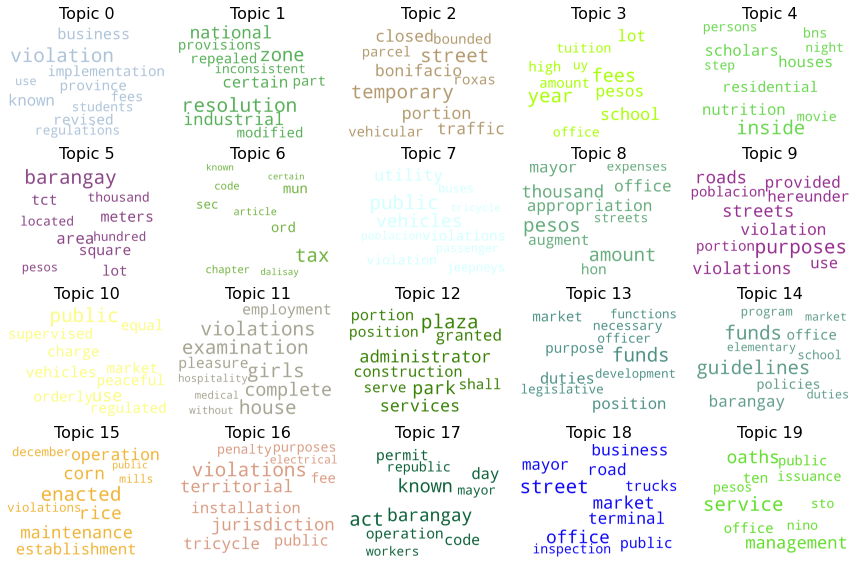

In [31]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab20',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(num_topics=20,formatted=False)

fig, axes = plt.subplots(4, 5, figsize=(12,8), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

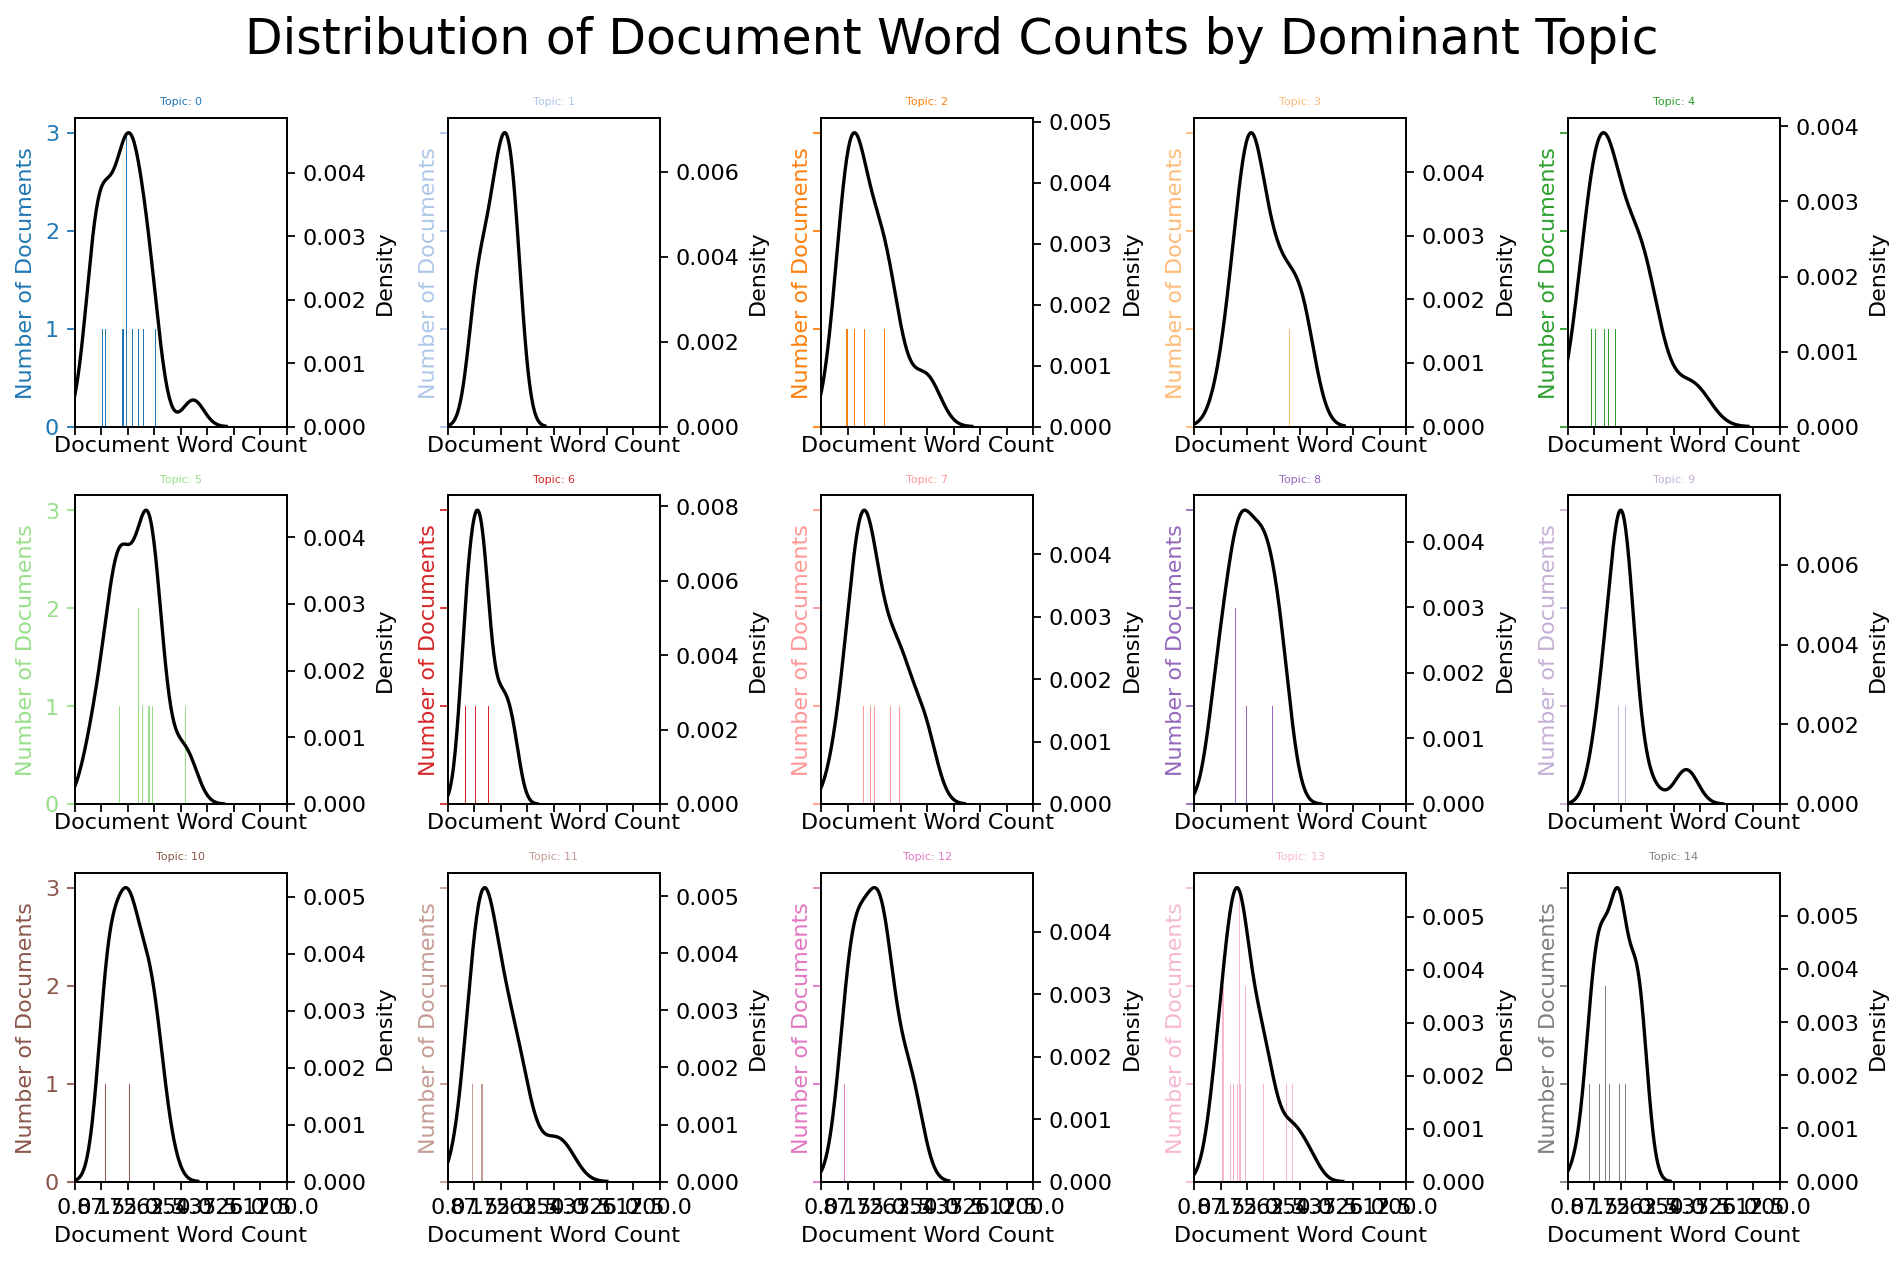

In [32]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(3,5,figsize=(12,8), dpi=160, sharex=True, sharey=True)
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)
    
for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 700, color=tableau20[i])
    ax.tick_params(axis='y', labelcolor=tableau20[i], color=tableau20[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 700), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=tableau20[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=5, color=tableau20[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,700,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

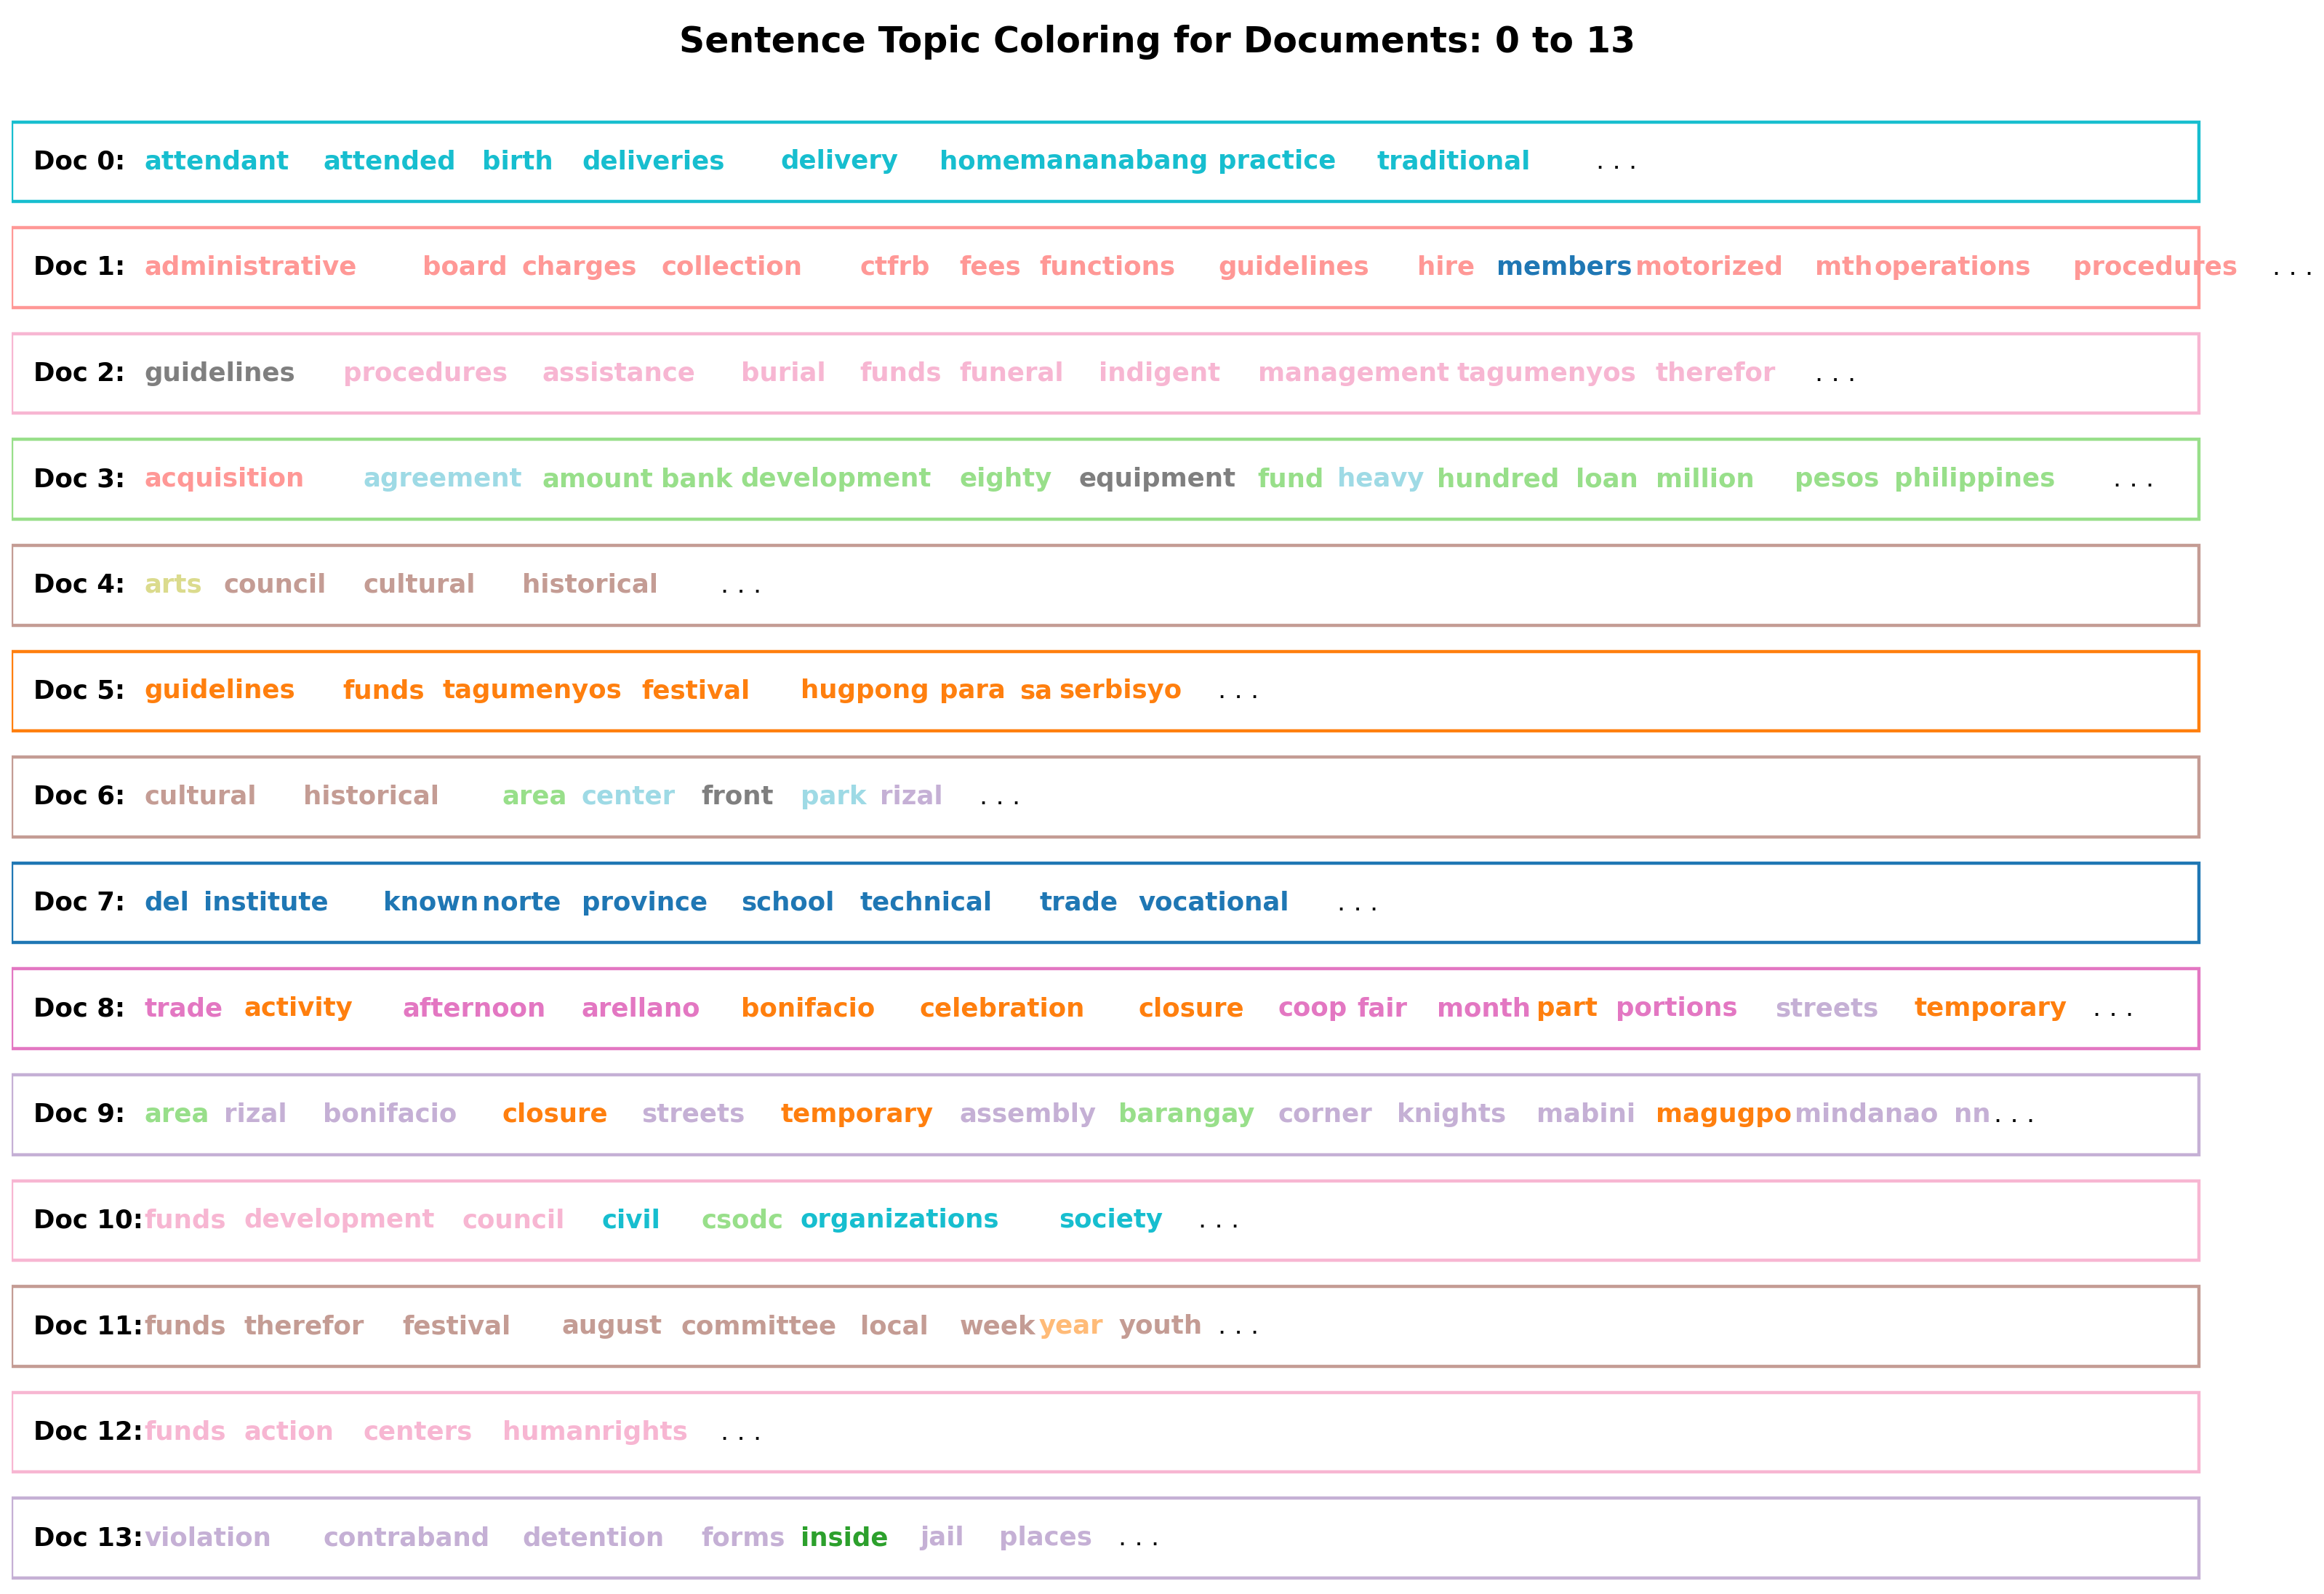

/Users/coriv/Developer/Ordinances_LDA/Ordinances_LDA/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/coriv/Developer/Ordinances_LDA/Ordinances_LDA/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/coriv/Developer/Ordinances_LDA/Ordinances_LDA/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/coriv/Developer/Ordinances_LDA/Ordinances_LDA/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative us

In [33]:

# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=optimal_model, corpus=corpus, start = 0, end = 15):
    corp = corpus[start:end]
    mycolors = tableau20

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()